# Neural Network Autoencoder Implementation
## Setup and Data Loading

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from nn.nn import NeuralNetwork

In [32]:
# Load dataset
digits = load_digits()
X = digits.data  # Shape (1797, 64)

# Normalize data to range [0, 1]
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into training and validation sets
X_train, X_val = train_test_split(X, test_size=0.2, random_state=42)

print(f"Data shape: {X.shape}")
print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Data shape: (1797, 64)
Training data shape: (1437, 64)
Validation data shape: (360, 64)


## Autoencoder Architecture and Training
The architecture is a simple 64-16-64 fully connected network where:

- Input layer: 64 neurons (matching the flattened 8x8 digit images)
- Hidden layer: 16 neurons (the compressed representation)
- Output layer: 64 neurons (to reconstruct the original input)

In [41]:
nn_arch = [
    {'input_dim': 64, 'output_dim': 16, 'activation': 'relu'},
    {'input_dim': 16, 'output_dim': 64, 'activation': 'sigmoid'}  
]

nn = NeuralNetwork(
    nn_arch=nn_arch, 
    lr=1,            
    seed=123,           
    batch_size=32,     
    epochs=1000,      
    loss_function='mean_squared_error')

# Train autoencoder
train_loss, val_loss = nn.fit(X_train, X_train, X_val, X_val)

## Analyzing Training Curves

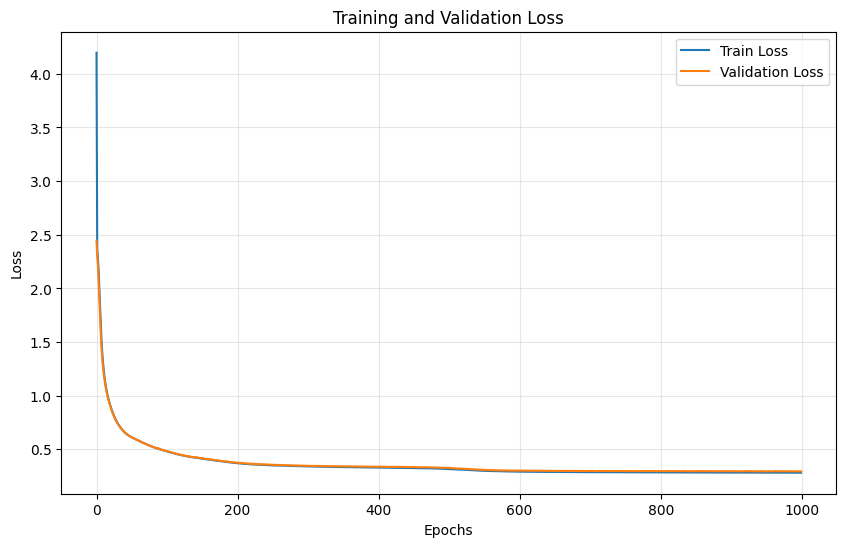

In [42]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('autoencoder_loss.png')
plt.show()

## Assessing Reconstruction

In [53]:
predictions = nn.predict(X_val)

Average reconstruction error (MSE) on validation set: 0.009206


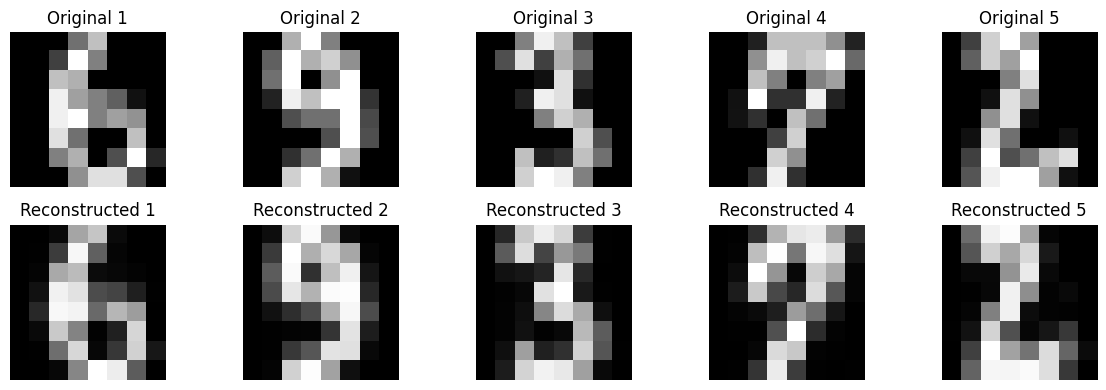

In [60]:

# Calculate mean squared error on validation set
mse = np.mean((predictions - X_val.T) ** 2)
print(f"Average reconstruction error (MSE) on validation set: {mse:.6f}")

# Visualize some reconstructions
def plot_reconstructions(original, reconstructed, n=5):
    plt.figure(figsize=(12, 4))
    for i in range(n):
        # Original image
        plt.subplot(2, n, i+1)
        plt.imshow(original[i].reshape(8, 8), cmap='gray')
        plt.title(f"Original {i+1}")
        plt.axis('off')
        
        # Reconstructed image
        plt.subplot(2, n, i+n+1)
        plt.imshow(reconstructed[i].reshape(8, 8), cmap='gray')
        plt.title(f"Reconstructed {i+1}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('reconstructions.png')
    plt.show()

# Plot first 5 validation samples
plot_reconstructions(X_val, predictions.T)

## Hyperparameter Choices

1. Architecture (64-16-64):
   - Input/Output size (64) matches the dimensionality of the MNIST digits data
   - Latent space (16) provides 4x compression while retaining enough information for reconstruction
   - Single hidden layer keeps the model simple while demonstrating autoencoder concept


2. Learning Rate (**1**):
   - This is a surprisingly large value, but it actually worked, kind-of unsure why but I think these things are fairly unexplainable


3. Activation Functions:
   - ReLU for hidden layer: Addresses vanishing gradient problem and provides non-linearity
   - Sigmoid for output layer: Constrains output to [0,1] range matching our normalized input data


4. Batch Size (32):
   - Standard size that balances between computational efficiency and gradient noise
   - Small enough to help escape local minima but large enough for efficient computation


5. Loss Function (MSE):
   - Appropriate for reconstruction tasks with continuous values
   - Directly measures pixel-wise reconstruction quality


6. Epochs (1000):
   - Sufficient training time to reach convergence
   - Early stopping could be implemented to prevent overfitting


---

# Classifier for Transcription Factor Binding Sites
## Setup and Data Loading


In [97]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from nn.io import read_text_file, read_fasta_file
from nn.preprocess import sample_seqs, one_hot_encode_seqs
from nn.nn import NeuralNetwork
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Set random seed for reproducibility
np.random.seed(42)

# Load positive and negative examples
positive_sequences = read_text_file('./data/rap1-lieb-positives.txt')
negative_sequences = read_fasta_file('./data/yeast-upstream-1k-negative.fa')

print(f"Number of positive sequences: {len(positive_sequences)}")
print(f"Number of negative sequences: {len(negative_sequences)}")

# Check sequence lengths
pos_lengths = [len(seq) for seq in positive_sequences]
neg_lengths = [len(seq) for seq in negative_sequences]

print(f"Positive sequence length: min={min(pos_lengths)}, max={max(pos_lengths)}, median={np.median(pos_lengths)}")
print(f"Negative sequence length: min={min(neg_lengths)}, max={max(neg_lengths)}, median={np.median(neg_lengths)}")

Number of positive sequences: 137
Number of negative sequences: 3163
Positive sequence length: min=17, max=17, median=17.0
Negative sequence length: min=52, max=1000, median=1000.0


## Data pre-processing


For the sample_seqs function, I implemented a balanced sampling approach that:

1. Keeps all 137 positive examples (Rap1 binding sites) since they're rare and valuable
2. Randomly samples an equal number of negative examples to create a balanced dataset
3. This 1:1 ratio prevents class imbalance issues during training and allows the model 
   to learn distinguishing features without bias toward the majority class
4. The random sampling from negative examples introduces diversity in the training data

This balanced approach is crucial for transcription factor binding prediction where:
- False positives and false negatives are equally problematic
- The natural distribution (few binding sites, many non-binding sites) would bias 
  the model toward predicting everything as negative
- Equal representation ensures the model learns meaningful patterns in binding sites


In [98]:
# Create labels (1 for positive, 0 for negative)
all_sequences = positive_sequences + negative_sequences
print(f"Before sampling: {len(all_sequences)} sequences")
print(f"Positive sequences: {len(positive_sequences)}")
print(f"Negative sequences: {len(negative_sequences)}")

labels = np.zeros(len(all_sequences), dtype=int)
labels[:len(positive_sequences)] = 1

# Sample sequences to balance the dataset
sampled_sequences, sampled_labels = sample_seqs(all_sequences, labels)

print(f"After sampling: {len(sampled_sequences)} sequences")
print(f"Positive sequences: {np.sum(sampled_labels)}")
print(f"Negative sequences: {len(sampled_labels) - np.sum(sampled_labels)}")

# One-hot encode the sequences
X = one_hot_encode_seqs(sampled_sequences)
y = np.array(sampled_labels).reshape(-1, 1)

print(f"Input shape: {X.shape}")
print(f"Output shape: {y.shape}")

Before sampling: 3300 sequences
Positive sequences: 137
Negative sequences: 3163
After sampling: 6326 sequences
Positive sequences: 3163
Negative sequences: 3163
Input shape: (6326, 4000)
Output shape: (6326, 1)


## Train-Validation Split


In [99]:
from sklearn.model_selection import train_test_split

# After sampling and one-hot encoding
X = one_hot_encode_seqs(sampled_sequences)
y = np.array(sampled_labels).reshape(-1, 1)

# Simple train-test split with sklearn
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=123)

print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Validation set shape: {X_val.shape}, {y_val.shape}")
print(f"Training positives: {np.sum(y_train)}/{len(y_train)} ({np.sum(y_train)/len(y_train)*100:.1f}%)")
print(f"Validation positives: {np.sum(y_val)}/{len(y_val)} ({np.sum(y_val)/len(y_val)*100:.1f}%)")

Training set shape: (5060, 4000), (5060, 1)
Validation set shape: (1266, 4000), (1266, 1)
Training positives: 2525/5060 (49.9%)
Validation positives: 638/1266 (50.4%)


## Model Architecture and Training


In [100]:
# Define neural network architecture
input_dim = X_train.shape[1]  # Number of features (one-hot encoded sequence length * 4)

nn_architecture = [
    {'input_dim': input_dim, 'output_dim': 64, 'activation': 'relu'},
    {'input_dim': 64, 'output_dim': 32, 'activation': 'relu'},
    {'input_dim': 32, 'output_dim': 1, 'activation': 'sigmoid'}
]

# Initialize neural network
nn_model = NeuralNetwork(
    nn_arch=nn_architecture,
    lr=0.01,
    seed=42,
    batch_size=32,
    epochs=100,
    loss_function='binary_cross_entropy'
)

# Train model
train_losses, val_losses = nn_model.fit(X_train, y_train, X_val, y_val)

## Analyzing Training Results

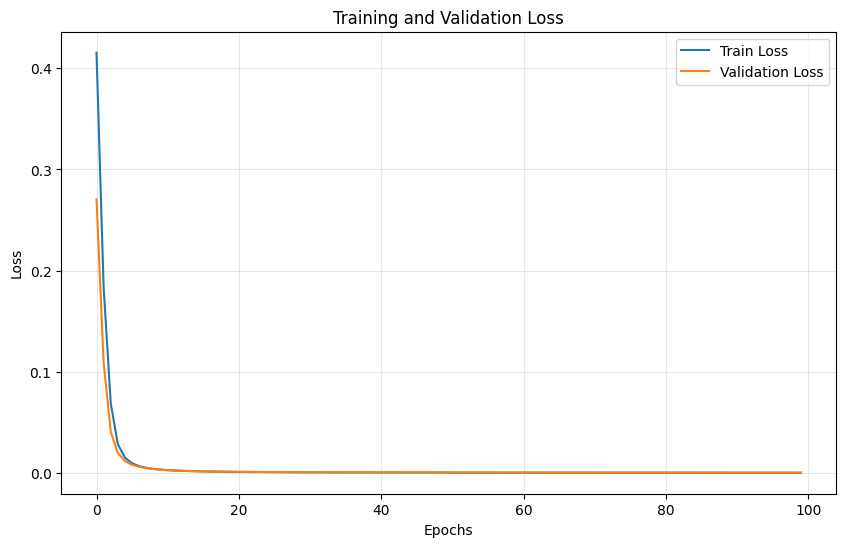

Best model at epoch 99 with validation loss: 0.000154


In [101]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('classifier_loss.png')
plt.show()

# Early stopping detection
best_epoch = np.argmin(val_losses)
print(f"Best model at epoch {best_epoch} with validation loss: {val_losses[best_epoch]:.6f}")

## Model Evaluation

In [104]:
# Get predictions on validation set
y_pred_prob = nn_model.predict(X_val)

# Convert probabilities to binary predictions
y_pred = (y_pred_prob >= 0.5).astype(int)


In [105]:
accuracy = np.mean(y_pred == y_val.T)
print(f"Validation accuracy: {accuracy:.4f}")

Validation accuracy: 1.0000


Seems that the classification is perfect LOL

In [106]:
confusion_matrix(y_val, y_pred.T)

array([[628,   0],
       [  0, 638]])


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       628
           1       1.00      1.00      1.00       638

    accuracy                           1.00      1266
   macro avg       1.00      1.00      1.00      1266
weighted avg       1.00      1.00      1.00      1266



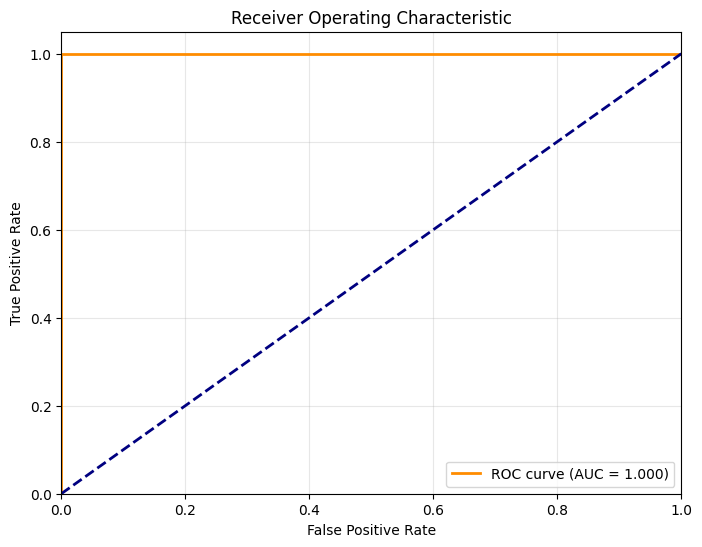

In [107]:

# Print classification report
print("\nClassification Report:")
print(classification_report(y_val, y_pred.T))

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_val, y_pred_prob.T)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.savefig('roc_curve.png')
plt.show()


### Loss Function and Hyperparameter Selection:

1. Binary Cross-Entropy Loss:
   - Appropriate for binary classification problems
   - Penalizes wrong predictions based on their confidence

2. Three-Layer Architecture:
   - Input layer matches one-hot encoded sequence length
   - First hidden layer (64 neurons) allows the model to learn basic sequence patterns
   - Second hidden layer (32 neurons) allows the model to learn more complex combinations
   - Single output neuron with sigmoid activation for binary classification

3. Learning Rate (0.01):
   - Moderate value that balances between convergence speed and stability
   - Small enough to avoid oscillation but large enough for efficient training
   - Also just worked the best lol

4. Batch Size (32):
   - Standard size that balances between computational efficiency and gradient noise
   - Provides sufficient statistics for each update while maintaining diversity

5. ReLU Activation:
   - Helps with the vanishing gradient problem
   - Fast to compute and widely effective for hidden layers
   - Allows for sparse activation patterns



**I'm slightly suspicious about the classifier / autoencoder doing this well, if you find any obvious issues I'm very curious to know**

One of my theories is that positive sequences are way smaller in length (model is probably learning that any amount of padding = positive sequence)